# Importing Modules and Data

In [1]:
import Network
import Learning
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
#https://www.ajbell.co.uk/market-research/sub/FUND:BJS8SJ3/charts-performance

In [2]:
fidelityDF = pd.read_csv('Fidelity Index World P Acc.csv')
fidelityDF = fidelityDF.reset_index()
fidelityDF = fidelityDF.drop(['Date','NAV'],axis=1)
fidelityDF.rename(columns = {'index':'Date','Name':'Open'}, inplace = True)

fidData = np.asarray(fidelityDF['Open'])
fidDates = np.asarray(fidelityDF['Date'])
date_objects = [datetime.strptime(date, "%m/%d/%Y") for date in fidDates]
time_differences = [(date - date_objects[0]).days for date in date_objects]
int_dates = [int(diff) for diff in time_differences]
#print(int_dates)

fidelityDF.head(10)

,Date,Open
0,12/10/2012,0.81261
1,12/11/2012,0.81667
2,12/12/2012,0.81830
3,12/13/2012,0.81911
4,12/14/2012,0.81667
5,12/17/2012,0.81115
6,12/18/2012,0.82074
7,12/19/2012,0.82318
8,12/20/2012,0.82318
9,12/21/2012,0.81749


# Defining the Broker and Relevant Functions

In [3]:
class broker:
    def __init__(self,data,dates,func):
        self.cash = 0 # starts with 1.0 cash
        self.indexSum = 1
        self.dateIndex = 0 
        self.dates = dates
        self.data = data / data[0] # index is normalised to 1.0 start
        self.maxDate = len(data)
        self.func = func

        self.totalValue = np.zeros(len(data))
        self.indexValue = np.zeros(len(data))
        self.cashValue = np.zeros(len(data))
        
        
        if len(data) != len(dates):
            print('Error: data length does not match date length')
            
    def buy(self,value: float):
        if value > self.cash:
            value = self.cash
            #print('Warning Buy Cash greater than amount held. DateIndex/Date=',self.dateIndex,self.dates[self.dateIndex])
        
        self.cash = self.cash - value
        self.indexSum = self.indexSum + value/self.data[self.dateIndex]
        
        
    def sell(self,value: float):
        if value > self.indexSum:
            value = self.indexSum
            #print('Warning Sell Value greater than amount held. DateIndex/Date=',self.dateIndex,self.dates[self.dateIndex])
        
        self.indexSum = self.indexSum - value
        self.cash = self.cash + value*self.data[self.dateIndex]
            
    def makeMove(self):
        seenData = self.data[:self.dateIndex+1] #if dateIndex is 0 it is first day
        seenDates = self.dates[:self.dateIndex+1]

        # function here using seen data that returns a number between 0 and 1
        # 1 being all value in cash, 0 being all value in stock
        action = self.func(seenData,seenDates) # add function here
        
        if action == -1: #pass
            pass
        else:

            currentValue = self.cash + self.indexSum * self.data[self.dateIndex] # current value of portfolio
            wantedValue = action * currentValue # wanted value in cash

            if self.cash > wantedValue: #if we have more cash than wanted
                #buy
                cashValue = self.cash-wantedValue
                self.buy(cashValue)

            elif self.cash < wantedValue: #if we have less cash than wanted
                #sell
                cashValue = wantedValue - self.cash
                indexValue = cashValue/self.data[self.dateIndex]
                self.sell(indexValue)

        self.indexValue[self.dateIndex] = self.indexSum
        self.cashValue[self.dateIndex] = self.cash
        self.totalValue[self.dateIndex] = self.cash + self.indexSum * self.data[self.dateIndex]
        self.dateIndex += 1 # after move is made, move to next date
        
    def run(self):
        for i in range(self.maxDate-self.dateIndex):
            self.makeMove()
            
    def plot(self,dataName: str):
        ax = plt.gca()
        plotDF = pd.DataFrame()
        plotDF['Dates'] = self.dates
        plotDF['Index'] = self.data
        plotDF['Trader'] = self.totalValue
        
        plotDF.plot(x='Dates',y='Trader',ax=ax)
        plotDF.plot(x='Dates',y='Index',ax=ax,label=dataName)
        plt.xticks(rotation=90)
        '''
        plt.plot(self.dates,self.data,label = dataName)
        plt.plot(self.dates,self.totalValue,label = 'Trader')
        
        plt.title(dataName+' vs Trader Performance')
        plt.legend()
        '''

        
def testData():
    return np.arange(1,101) + np.random.uniform(-10,10,100) + 100, np.arange(0,200,2)

def getData(ticker,df):
    DF = df.drop(df[df['Ticker']!=ticker].index)
    Data = np.asarray(DF['Open'],dtype=float)
    Dates = np.asarray(DF['Date'])
    return Data,Dates

def linearMemoryDiff(seenData,seenDates,memory=0):
    '''
    function to fit a linear regression to 
    memory number of datapoints back
    then take the difference of the 
    predicted vs actual value
    '''
    if memory == 0:
        return 0
    else:
        seenData = seenData[-memory:]
        seenDates = seenDates[-memory:]
    
    x = np.arange(0, len(seenData))
    y = seenData
    
    coeffs = np.polyfit(x, y, 1)
    fit = np.poly1d(coeffs)
    
    predictedValue = fit(x[-1])

    return seenData[-1]/predictedValue - 1



# Testing Variable Buy Sell Bot

In [4]:
# creating Input Data from varing linear regression sizes
memory_lengths = [10,20,40,60,100,150,200,300,400,500,600,700,800,900,1000,1500,2000,len(fidData)]

input_matrix = np.zeros((len(fidData),len(memory_lengths)))
print(input_matrix.shape)

for i in range(len(fidData)-1):
    i = i + 1
    seenData = fidData[:i]
    seenDates = int_dates[:i]
    for j in range(len(memory_lengths)):
        if i == 1:
            pass
        else:
            input_matrix[i][j] = linearMemoryDiff(seenData,seenDates,memory_lengths[j])

(2708, 18)


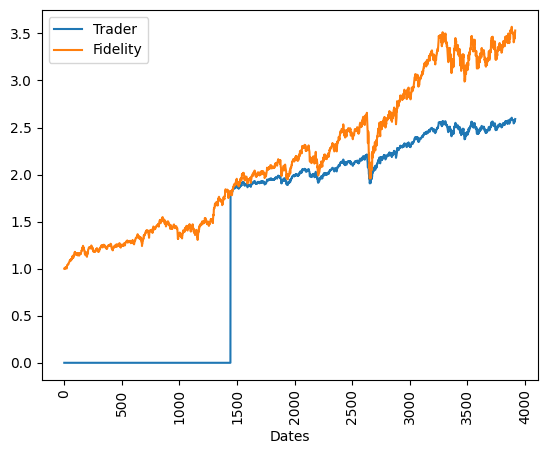

In [5]:
# test network can run
net1 = Network.network(18,1)
net1.add_layer(Network.layer_dense(18,1))
net1.add_layer(Network.sigmoid())

bot = lambda seenData,seenDates: net1.forward([input_matrix[len(seenData)-1]])[0][0]
FID = broker(fidData,int_dates,bot)
FID.dateIndex = 1000
FID.run()
FID.plot('Fidelity')

In [39]:
# load network if already saved
net1 = Network.load_network_from_file('1000StartIndexPricing18Inputs.pkl')

In [169]:
# learning starts here

def loss_func(net):
    bot = lambda seenData,seenDates: net1.forward([input_matrix[len(seenData)-1]])[0][0]
    FID = broker(fidData,int_dates,bot)
    FID.dateIndex = 1000
    FID.run()
    return 1/FID.totalValue[-1]

loss,data = Learning.random_learning(net1,loss_func,info=True,max_mutations=100)
net1.save_to_file('1000StartIndexPricing18Inputs.pkl')

Iter 0 Loss 0.1433130900266137
Iter 1 Loss 0.14331194833209585
Iter 2 Loss 0.14331128139664936
Iter 3 Loss 0.14330880561893816
Iter 4 Loss 0.14330857711499118
Iter 5 Loss 0.143307501830021
Iter 6 Loss 0.14330652189473544
Iter 7 Loss 0.14330621859458217
Iter 8 Loss 0.14330495899247883
Iter 9 Loss 0.14330457131787505
Iter 10 Loss 0.1433029697117196
Iter 11 Loss 0.1433021102461955
Iter 12 Loss 0.1433001762216819
Iter 13 Loss 0.143299149051119
Iter 14 Loss 0.14329830080315709
Iter 15 Loss 0.1432976918374114
Iter 16 Loss 0.1432974422943163
Iter 17 Loss 0.1432958442096451
Iter 18 Loss 0.14329493624789943
Iter 19 Loss 0.14329386478499972
Iter 20 Loss 0.14329323311353123
Iter 21 Loss 0.14329278876335672
Iter 22 Loss 0.14329252817511132
Iter 23 Loss 0.1432916971008536
Iter 24 Loss 0.14328935173101867
Iter 25 Loss 0.14328922992724552
Iter 26 Loss 0.1432890375712785
Iter 27 Loss 0.1432872293428776
Iter 28 Loss 0.14328706804583494
Iter 29 Loss 0.143286919885094
Iter 30 Loss 0.14328542422180568
Ite

7.010077863906536


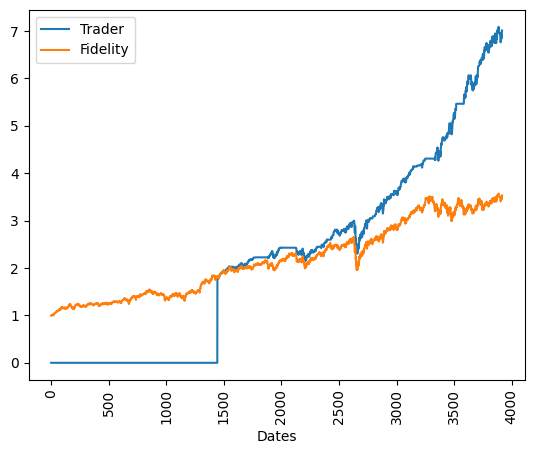

In [172]:
# performance
FID = broker(fidData,int_dates,bot)
FID.dateIndex = 1000
FID.run()
print(FID.totalValue[-1])
FID.plot('Fidelity')

(0.0, 1.0)

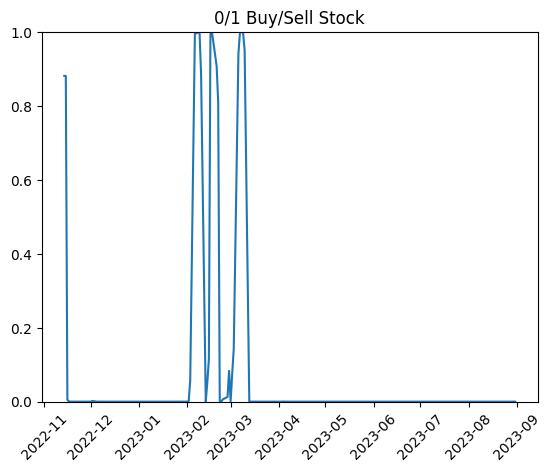

In [174]:
# buy/sell indicators from the last 200 days
plt.plot(date_objects[-200:],net1.forward(input_matrix[-200:]))
plt.xticks(rotation=45)
plt.title('0/1 Buy/Sell Stock')
plt.ylim([0,1])

Todays Data 2.8693 08/31/2023


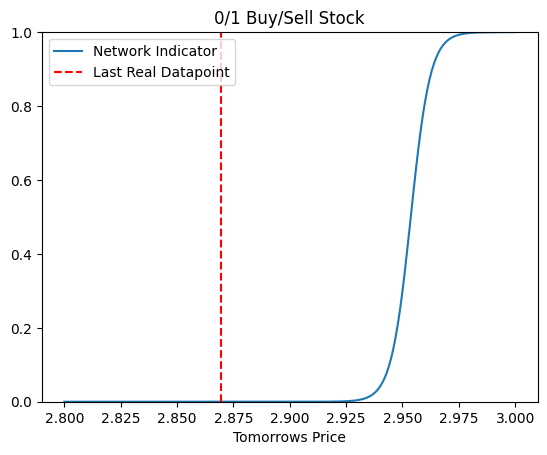

In [220]:
# create an artificial datapoint tomorrow and see how the network responds
def artificalVector(num):
    data = fidData[:]
    dates = int_dates[:]

    data = np.array(list(data) + [num])
    dates = np.array(list(dates) + [dates[-1]+1])
    
    output = np.zeros(len(memory_lengths))
    for i,mem in enumerate(memory_lengths):
        if i == len(memory_lengths) - 1:
            output[i] = linearMemoryDiff(data,dates,len(data))
        else:
            output[i] = linearMemoryDiff(data,dates,mem)

    return output

print('Todays Data',fidData[-1],fidDates[-1])

tomorrowData = np.arange(2.8,3,0.001)

prediction = [net1.forward([artificalVector(num)])[0][0] for num in tomorrowData]
plt.plot(tomorrowData,prediction,label='Network Indicator')
plt.axvline(x=fidData[-1],color='r', linestyle='--' ,label='Last Real Datapoint')
plt.ylim([0,1])
plt.xlabel('Tomorrows Price')
plt.title('0/1 Buy/Sell Stock')
plt.legend()

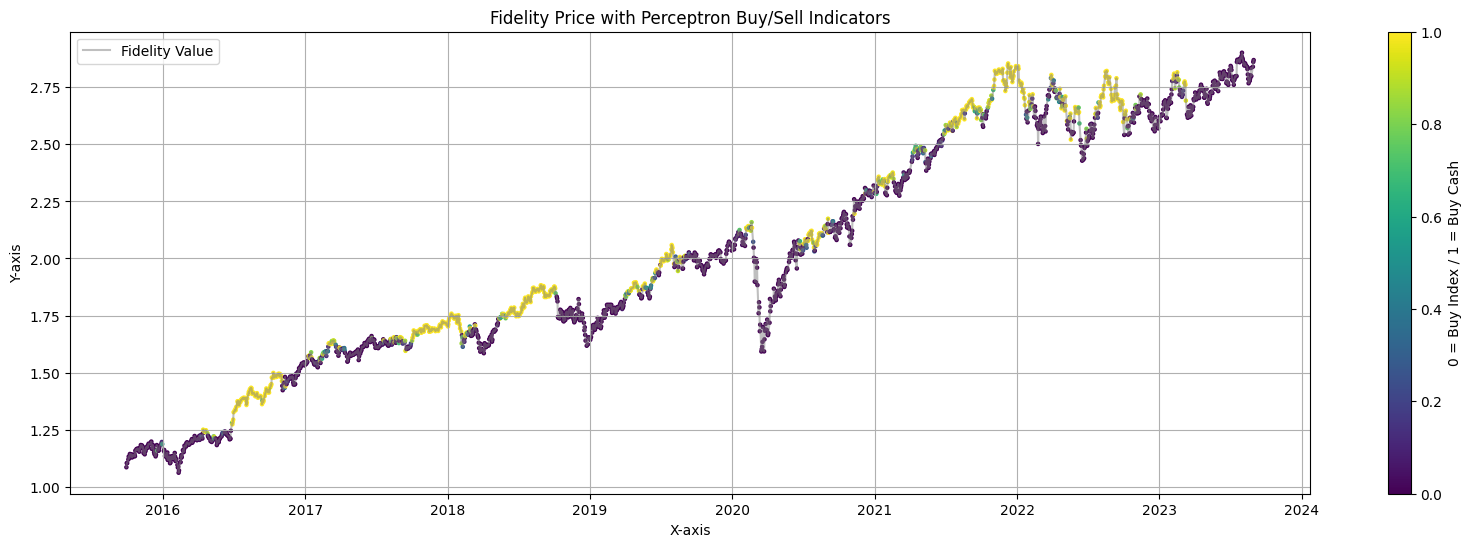

In [218]:
# Plot Indicator on Full Data Range
days = 2000

X = date_objects[-days:]
Y = fidData[-days:]
colour = [net1.forward([row])[0][0] for row in input_matrix[-days:]]  # Assuming 'colour' represents values between 0 and 1

# Create the plot with varying line color
plt.figure(figsize=(20, 6))  # Adjust the figure size as needed
plt.plot(X,Y,'grey',alpha=0.5,label='Fidelity Value')
plt.scatter(X, Y, c=colour, cmap='viridis', s=10000/days,vmin=0,vmax=1)  # Adjust the 's' parameter for marker size


# Add a colorbar to indicate the color mapping
plt.colorbar(label='0 = Buy Index / 1 = Buy Cash')

# Add labels and a title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Fidelity Price with Perceptron Buy/Sell Indicators')
plt.legend()
plt.grid()

# Show the plot
plt.show()


# Looking to more complex networks

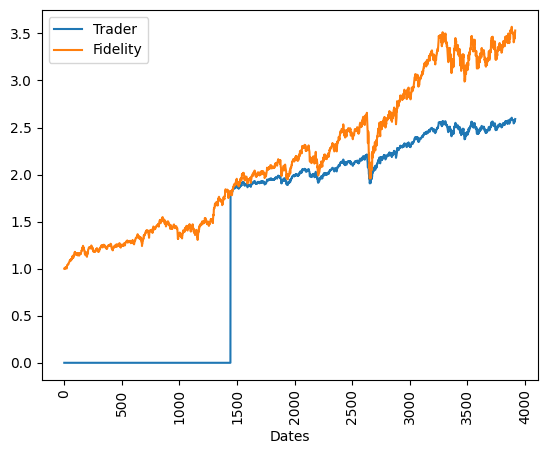

In [122]:
deepNet = Network.network(18,1)
deepNet.add_layer(Network.layer_dense(18,12))
deepNet.add_layer(Network.sigmoid())
deepNet.add_layer(Network.layer_dense(12,6))
deepNet.add_layer(Network.sigmoid())
deepNet.add_layer(Network.layer_dense(6,6))
deepNet.add_layer(Network.sigmoid())
deepNet.add_layer(Network.layer_dense(6,6))
deepNet.add_layer(Network.sigmoid())
deepNet.add_layer(Network.layer_dense(6,1))
deepNet.add_layer(Network.sigmoid())

botDeep = lambda seenData,seenDates: deepNet.forward([input_matrix[len(seenData)-1]])[0][0]
FID = broker(fidData,int_dates,botDeep)
FID.dateIndex = 1000
FID.run()
FID.plot('Fidelity')

In [150]:
deepNet = Network.load_network_from_file('18-12-6-6-1,bot.pkl')

In [164]:
# learning starts here

def deep_loss_func(net):
    botDeep = lambda seenData,seenDates: deepNet.forward([input_matrix[len(seenData)-1]])[0][0]
    FID = broker(fidData,int_dates,botDeep)
    FID.dateIndex = 1000
    FID.run()
    return 1/FID.totalValue[-1]

loss,data = Learning.random_learning(deepNet,deep_loss_func,info=True,max_mutations=100)
deepNet.save_to_file('18-12-6-6-1,bot.pkl')

Iter 0 Loss 0.1514568521181107
Iter 1 Loss 0.15139518210879463
Iter 2 Loss 0.15131670851430856
Iter 3 Loss 0.15110291342479668
Iter 4 Loss 0.15070084323661423
Iter 5 Loss 0.150623260652337
Iter 6 Loss 0.1503814748411011
Iter 7 Loss 0.15029731787511638
Iter 8 Loss 0.15015262250703498
Iter 9 Loss 0.14963895506687946
Iter 10 Loss 0.14959428529989088
Iter 11 Loss 0.14954821233697374
Iter 12 Loss 0.14954243973163953
Iter 13 Loss 0.1493909715065036
Iter 14 Loss 0.14917505366211287
Iter 15 Loss 0.14913405743491945
Iter 16 Loss 0.14892990317265287
Iter 17 Loss 0.1487193100327946
Iter 18 Loss 0.14866692264241183
Iter 19 Loss 0.1485553108625889
Iter 20 Loss 0.14847644624138923
Iter 21 Loss 0.1484561319502015
Iter 22 Loss 0.1479102411945994
Iter 23 Loss 0.1479089214460905
Iter 24 Loss 0.1478386903051515
Stopped Due to Max Mutations Reached


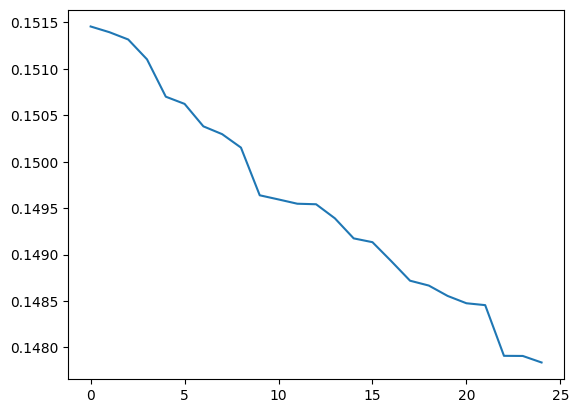

In [165]:
plt.plot(loss)

6.764129186587875


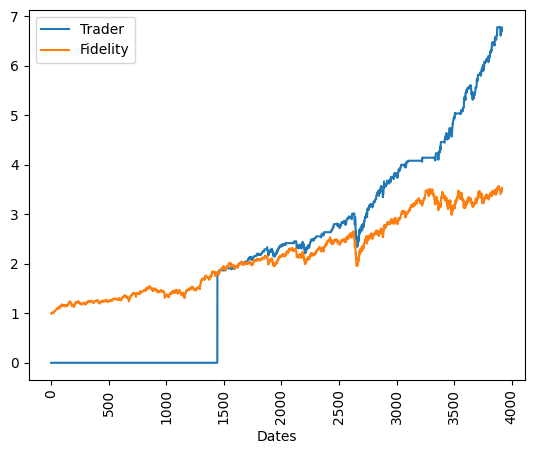

In [166]:
FID = broker(fidData,int_dates,botDeep)
FID.dateIndex = 1000
FID.run()
print(FID.totalValue[-1])
FID.plot('Fidelity')

(0.0, 1.0)

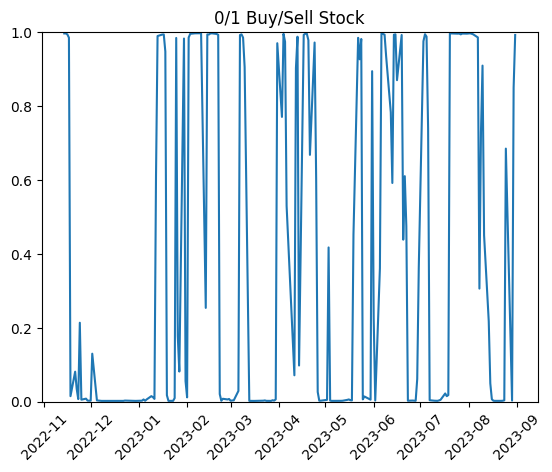

In [176]:
plt.plot(date_objects[-200:],deepNet.forward(input_matrix[-200:]),'-')
plt.xticks(rotation=45)
plt.title('0/1 Buy/Sell Stock')
plt.ylim([0,1])

Todays Data 2.8693 08/31/2023


Text(0.5, 1.0, '0/1 Buy/Sell Stock')

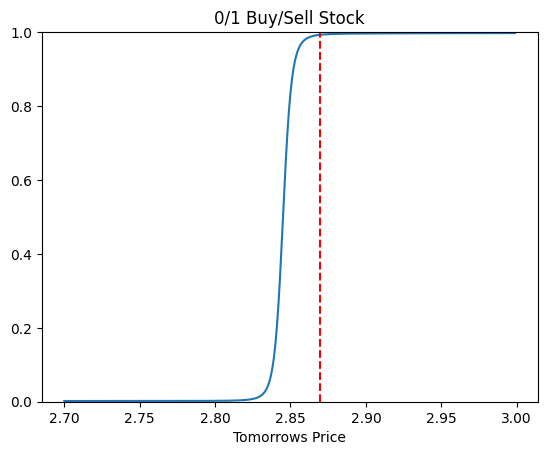

In [177]:
print('Todays Data',fidData[-1],fidDates[-1])
tomorrowData = np.arange(2.7,3,0.001)
prediction = [deepNet.forward([artificalVector(num)])[0][0] for num in tomorrowData]
plt.plot(tomorrowData,prediction)
plt.axvline(x=fidData[-1],color='r', linestyle='--' )
plt.ylim([0,1])
plt.xlabel('Tomorrows Price')
plt.title('0/1 Buy/Sell Stock')

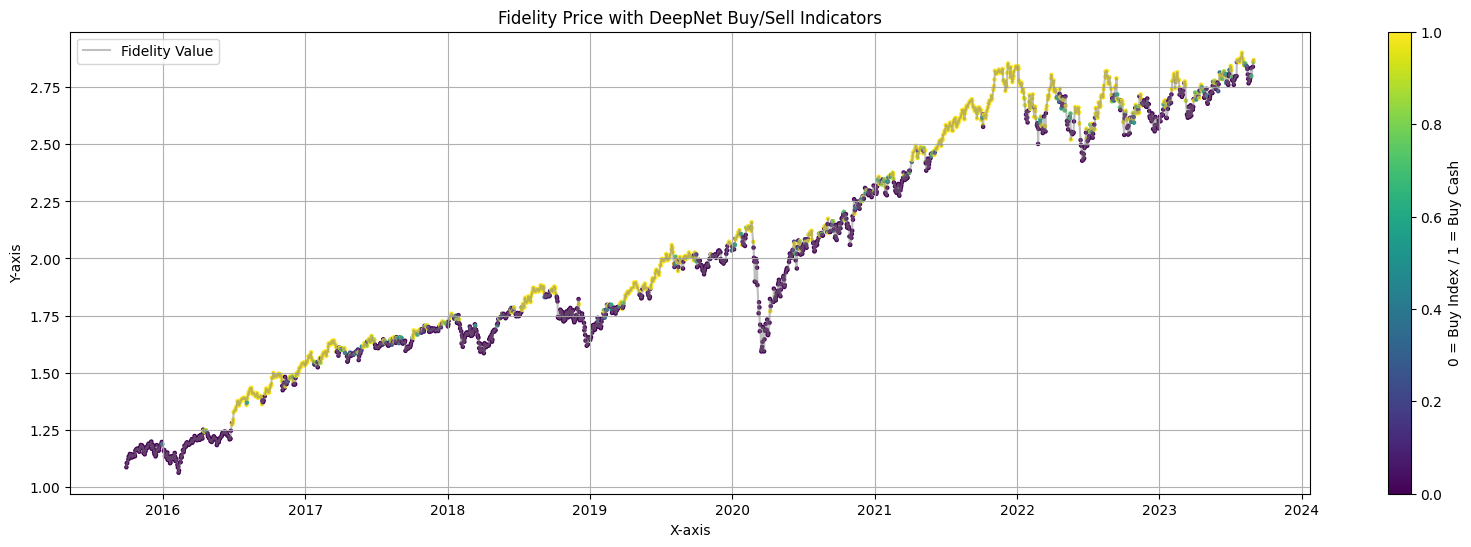

In [219]:
# Generate some sample data
days = 2000

X = date_objects[-days:]
Y = fidData[-days:]
colour = [deepNet.forward([row])[0][0] for row in input_matrix[-days:]]  # Assuming 'colour' represents values between 0 and 1

# Create the plot with varying line color
plt.figure(figsize=(20, 6))  # Adjust the figure size as needed
plt.plot(X,Y,'grey',alpha=0.5,label='Fidelity Value')
plt.scatter(X, Y, c=colour, cmap='viridis', s=10000/days,vmin=0,vmax=1)  # Adjust the 's' parameter for marker size


# Add a colorbar to indicate the color mapping
plt.colorbar(label='0 = Buy Index / 1 = Buy Cash')

# Add labels and a title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Fidelity Price with DeepNet Buy/Sell Indicators')
plt.legend()
plt.grid()

# Show the plot
plt.show()
